In [7]:
import basedosdados as bd
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from plotnine import *

In [2]:
query = """
SELECT  DISTINCT id_municipio, nome FROM `basedosdados.br_denatran_frota.municipio_tipo` 
INNER JOIN `basedosdados.br_bd_diretorios_brasil.municipio` USING (id_municipio, sigla_uf)
GROUP BY sigla_uf, id_municipio, ano, mes, nome

HAVING COUNT(*) > 1
ORDER BY id_municipio"""
frota = bd.read_sql(query, billing_project_id="python-371123")
frota

Downloading: 100%|██████████| 11/11 [00:00<00:00, 33.89rows/s]


,id_municipio,nome
0,1100809,Candeias do Jamari
1,1600105,Amapá
2,1705102,Chapada da Natividade
3,2402105,Campo Redondo
4,2403509,Espírito Santo
5,2501575,Barra de Santana
6,2507408,Jericó
7,2513208,Santa Cruz
8,2513943,São Domingos do Cariri
9,4202438,Bocaina do Sul


In [24]:
query = """
SELECT id_estacao, data_fundacao, latitude, longitude, id_municipio as municipio
FROM `basedosdados.br_inmet_bdmep.estacao` 
"""

df = bd.read_sql(query, billing_project_id="python-371123")

Downloading: 100%|██████████| 612/612 [00:00<00:00, 1773.92rows/s]


In [16]:
query = """
SELECT precipitacao_total, data, id_estacao
FROM `basedosdados.br_inmet_bdmep.microdados`
WHERE EXTRACT(MONTH FROM data) = 10
  AND EXTRACT(YEAR FROM data) IN (2002, 2006, 2010, 2014, 2018, 2022)
  AND EXTRACT(HOUR FROM hora) >= 7
  AND EXTRACT(HOUR FROM hora) <= 17
  AND precipitacao_total IS NOT NULL
LIMIT 100000000
"""

df = bd.read_sql(query, billing_project_id="python-371123")

Downloading: 100%|██████████| 640808/640808 [00:25<00:00, 24813.06rows/s]


In [39]:
pd.read_csv("temp2.csv", index_col= 0).assign(data_fundacao = lambda _: pd.to_datetime(_.data_fundacao))

,id_estacao,data_fundacao,latitude,longitude,municipio
0,A001,2000-05-07,-15.789444,-47.925833,5300108.0
1,A042,2017-07-19,-15.599722,-48.131111,5300108.0
2,A045,2008-10-03,-15.596491,-47.625801,5300108.0
3,A046,2014-10-01,-15.935278,-48.137500,5300108.0
4,A047,2017-02-07,-16.012222,-47.557417,5300108.0
...,...,...,...,...,...
607,S113,2016-12-01,0.947778,-59.746389,1400233.0
608,S114,2016-12-01,4.477500,-61.149167,1400456.0
609,S122,2016-12-01,3.358889,-59.823889,1400159.0
610,A847,2007-03-23,-25.494444,-48.325833,4118204.0


In [65]:
df = pd.DataFrame()
for ano in range(2000, 2022):
    municipios = (pd.read_csv("script/municipios.csv", index_col=0)
    .filter(["id_municipio", "latitude", "longitude"])
    .assign(lat_rad = lambda _: np.deg2rad(_.latitude), 
            long_rad = lambda _: np.deg2rad(_.longitude))
        )
    estacoes = (pd.read_csv("temp2.csv", index_col= 0)
    .assign(data_fundacao = lambda _: pd.to_datetime(_.data_fundacao))
    .query(f"data_fundacao.dt.year <= {ano}")
    .filter(["id_estacao", "latitude", "longitude"])
    .assign(lat_rad = lambda _: np.deg2rad(_.latitude), 
            long_rad = lambda _: np.deg2rad(_.longitude))
        )
    coords = list(estacoes.assign(coord = lambda _: list(zip(_.lat_rad, _.long_rad))).coord)
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric="haversine").fit(coords)

    coords = list(municipios.assign(coord = lambda _: list(zip(_.lat_rad, _.long_rad))).coord)
    distances, indices = nbrs.kneighbors(coords)
    out = (municipios
    .assign(distancia = distances, NN = indices, ano = ano)
    .assign(distancia = lambda _: _.distancia * 6371)
    .merge(estacoes, left_on= "NN", right_index= True, how = "left")
    .filter(["id_municipio", "id_estacao", "distancia", "ano"]))

    df = pd.concat([df, out])
    
df = df.assign(ano = lambda _: pd.Categorical(_.ano))

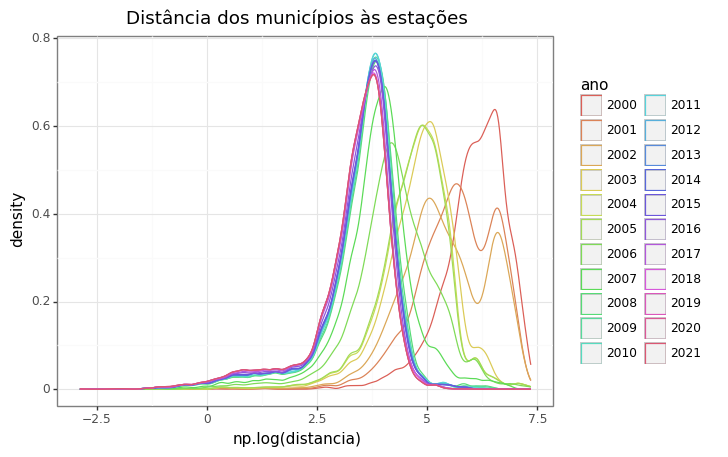

<ggplot: (119173074866)>

In [68]:
ggplot(df)+geom_density(aes("np.log(distancia)", color = "ano"))+theme_bw()+labs(title = "Distância dos municípios às estações")

In [42]:
municipios = (pd.read_csv("script/municipios.csv", index_col=0)
.filter(["id_municipio", "latitude", "longitude"])
.assign(lat_rad = lambda _: np.deg2rad(_.latitude), 
        long_rad = lambda _: np.deg2rad(_.longitude))
    )
estacoes = (pd.read_csv("temp2.csv", index_col= 0)
.filter(["id_estacao", "latitude", "longitude"])
.assign(lat_rad = lambda _: np.deg2rad(_.latitude), 
        long_rad = lambda _: np.deg2rad(_.longitude))
    )


In [9]:
coords = list(estacoes.assign(coord = lambda _: list(zip(_.lat_rad, _.long_rad))).coord)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric="haversine").fit(coords)

coords = list(municipios.assign(coord = lambda _: list(zip(_.lat_rad, _.long_rad))).coord)
distances, indices = nbrs.kneighbors(coords)

In [22]:
out = (municipios
 .assign(distancia = distances, NN = indices)
 .assign(distancia = lambda _: _.distancia * 6371)
 .merge(estacoes, left_on= "NN", right_index= True, how = "left")
 .filter(["id_municipio", "id_estacao", "distancia"]))

In [30]:
pd.read_csv("temp2.csv", index_col= 0).merge(out, left_on="municipio",right_on="id_municipio",how="left").assign(equal = lambda _: _.municipio == _.id_municipio).equal.sum()

610

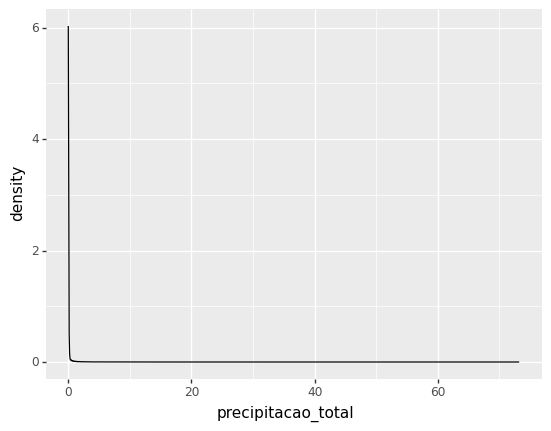

<ggplot: (156233924840)>

In [74]:
(
 pd.read_csv("temp.csv", index_col= 0)
 .pipe(lambda _: ggplot(_)+geom_density(aes("precipitacao_total")))
)

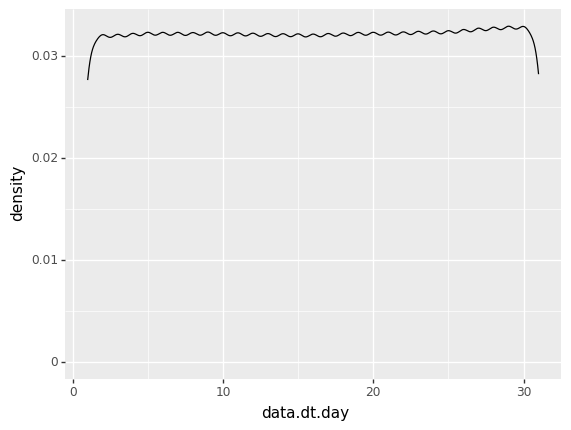

<ggplot: (156236759399)>

In [82]:
(
 pd.read_csv("temp.csv", index_col= 0)
 .assign(data= lambda _: pd.to_datetime(_.data))
 .pipe(lambda _: ggplot(_)+geom_density(aes("data.dt.day")))
)